In [1]:
import os 
BASE_DIR=os.path.abspath("../../")
import sys 
sys.path.append(BASE_DIR)
DATA_DIR="/home/arturosf/Documentos/repos/DeepElasticity/data/002-Neo"
from src.utils.data import DataNeo_2
from src.models import PINN  
from src.train import Trainer_2
import torch 
import matplotlib.pyplot as plt 
import time
from datetime import datetime
import pickle
import numpy as np  
from src.models import PINN_NeoHook


In [ ]:
E_values_str=["E10kPa","E15kPa","E20kPa","E25kPa","E30kPa"]
E_values_MPa=[0.01,0.015,0.02,0.025,0.03]

In [2]:
data=DataNeo_2("DATOS_HIPERELASTICO_3",5,E=e_val_str,base_dir=DATA_DIR)
data.load_data(load_stage=3)


In [4]:
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()


In [5]:
nu=0.4
E=e_val

lambda_=E*nu/((1+nu)*(1-2*nu)) #lame1
mu=E/(2*(1+nu)) #lame2
print(f"Lambda: {lambda_}",f"mu: {mu}")

0.01428571428571429 0.0035714285714285718


In [ ]:
def step_dict_fun_1(net):
    step_dict = {
        "step_1": {"optim": torch.optim.Adam(net.parameters(), lr=1e-2), 
                "epochs": 700},
        "step_2": {"optim": torch.optim.Adam(net.parameters(), lr=1e-3), 
                "epochs": 150},
        "step_3": {"optim": torch.optim.Adam(net.parameters(), lr=1e-4), 
                "epochs": 20}
    }
    return step_dict

def step_dict_fun_2(net):
    step_dict = {
        "step_1": {"optim": torch.optim.Adam(net.parameters(), lr=1e-3), 
                "epochs": 340},
        "step_2": {"optim": torch.optim.Adam(net.parameters(), lr=1e-2), 
                "epochs": 150},
        "step_3": {"optim": torch.optim.Adam(net.parameters(), lr=1e-4), 
                "epochs": 220}
    }
    return step_dict

lista_step_dict_funs=[step_dict_fun_1,step_dict_fun_2]

In [ ]:
#train lame 1 
lame_1_init_values=[10,1,0.1,0.01]

pinn=PINN_NeoHook([3,25,25,15,3],lame1_init,mu,train_lame2=False,train_lame1=True)


In [6]:

pinn=PINN_NeoHook([3,25,25,15,3],1,mu,train_lame2=False,train_lame1=True)
step_dict = {
    "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-2), 
            "epochs": 340},
    "step_2": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
            "epochs": 250},
    "step_3": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-4), 
            "epochs": 120}
}

In [7]:
step_dict=step_dict_fun_1(pinn)
trainer=Trainer_2(step_dict)
trainer.train(pinn,data)

step_1
Epoch:  1 loss:  0.5047264695167542
Epoch:  2 loss:  0.14213070273399353
Epoch:  3 loss:  0.06588056683540344
Epoch:  4 loss:  0.07895562052726746
Epoch:  5 loss:  0.08889228105545044
Epoch:  6 loss:  0.0987224355340004
Epoch:  7 loss:  0.08173885196447372
Epoch:  8 loss:  0.05044030770659447
Epoch:  9 loss:  0.031489696353673935
Epoch:  10 loss:  0.029564544558525085
Epoch:  11 loss:  0.03742598742246628
Epoch:  12 loss:  0.046074360609054565
Epoch:  13 loss:  0.04886411130428314
Epoch:  14 loss:  0.04386506229639053
Epoch:  15 loss:  0.03395228460431099
Epoch:  16 loss:  0.02507656067609787
Epoch:  17 loss:  0.02152915671467781
Epoch:  18 loss:  0.022772807627916336
Epoch:  19 loss:  0.02556554414331913
Epoch:  20 loss:  0.027668192982673645
Epoch:  21 loss:  0.028550688177347183
Epoch:  22 loss:  0.028059808537364006
Epoch:  23 loss:  0.025907864794135094
Epoch:  24 loss:  0.02251862734556198
Epoch:  25 loss:  0.01939242333173752
Epoch:  26 loss:  0.01805335469543934
Epoch:  

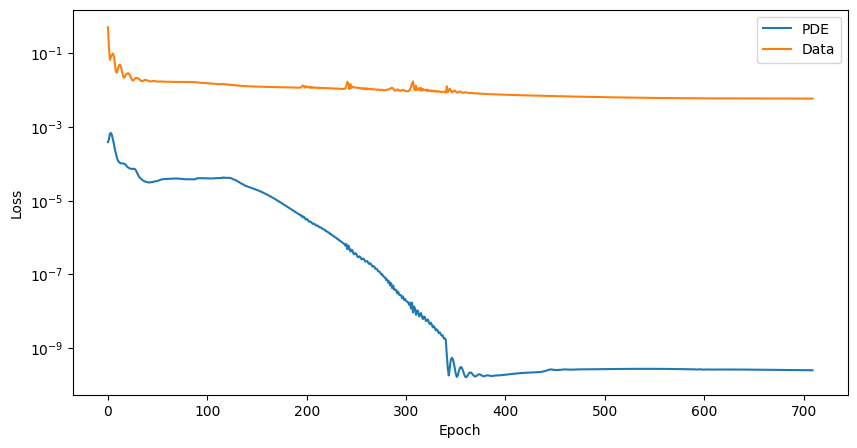

In [12]:
plt.figure(figsize=(10,5))
plt.plot(np.array(pinn.loss_history["PDE"]),label="PDE")
plt.plot(np.array(pinn.loss_history["Data"]),label="Data")
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(f"./results/loss_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")

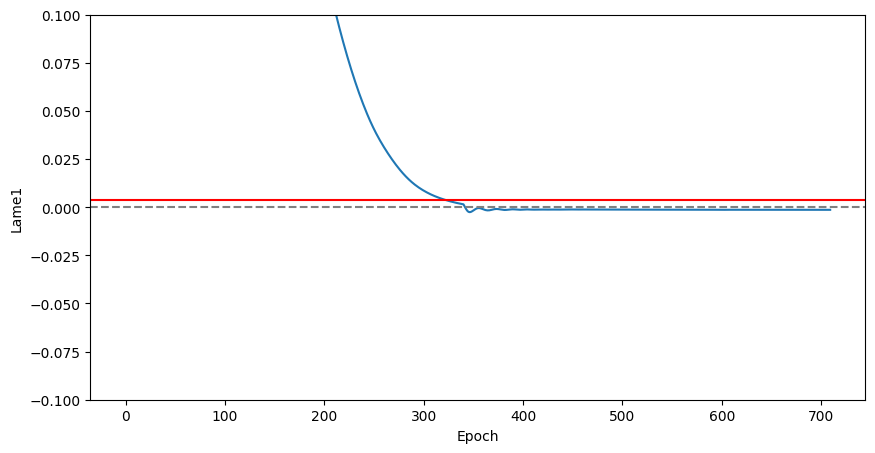

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.array(pinn.params_history["lame1"]),label="BC")
plt.axhline(mu,color="red")
plt.axhline(0,color="grey",linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Lame1")
plt.ylim(-0.1,0.1)
plt.savefig(f"./results/lame1_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")